In [1]:
# !pip install scalecast
# !pip install pandas_datareader
# !pip install statsmodels upgrade
# !pip install pmdarima
# !pip install dataframe-image

In [2]:
# import library
import numpy as np
from numpy import concatenate
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
import pandas as pd
from pandas import concat
from pandas import to_datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import pickle 

from scipy import stats
from math import sqrt
from scalecast.Forecaster import Forecaster
from datetime import datetime

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(8,6)})
import dataframe_image as dfi

import os
import itertools
import warnings
warnings.filterwarnings('ignore')

!python han-font.py
exec(open('han-font.py').read())

In [3]:
empty_emer=pd.read_csv('../DAT/empty_emer.csv',encoding = 'CP949')
empty_emer

,hospital_name,record_time,available_bed_num
0,의료법인강릉동인병원,20230623094352,15
1,강원특별자치도강릉의료원,20230623094001,4
2,강릉아산병원,20230623094001,10
3,근로복지공단동해병원,20230623094100,4
4,의료법인동해동인병원,20230623094403,0
...,...,...,...
14889,근로복지공단태백병원,20230628050400,9
14890,평창군보건의료원,20230628050500,7
14891,홍천아산병원,20230628044000,8
14892,화천군보건의료원,20230628050500,8


In [4]:
#병원 별로 데이터를 나누어줌
empty_emer1=empty_emer.loc[empty_emer.hospital_name=='의료법인강릉동인병원'].copy()
empty_emer2=empty_emer.loc[empty_emer.hospital_name=='강원특별자치도강릉의료원'].copy()
empty_emer3=empty_emer.loc[empty_emer.hospital_name=='강릉아산병원'].copy()
empty_emer4=empty_emer.loc[empty_emer.hospital_name=='근로복지공단동해병원'].copy()
empty_emer5=empty_emer.loc[empty_emer.hospital_name=='의료법인동해동인병원'].copy()
empty_emer6=empty_emer.loc[empty_emer.hospital_name=='강원특별자치도삼척의료원'].copy()
empty_emer7=empty_emer.loc[empty_emer.hospital_name=='강원특별자치도속초의료원'].copy()
empty_emer8=empty_emer.loc[empty_emer.hospital_name=='의료법인보광의료재단속초보광병원'].copy()
empty_emer9=empty_emer.loc[empty_emer.hospital_name=='의료법인성심의료재단양구성심병원'].copy()
empty_emer10=empty_emer.loc[empty_emer.hospital_name=='강원특별자치도영월의료원'].copy()
empty_emer11=empty_emer.loc[empty_emer.hospital_name=='강원특별자치도원주의료원'].copy()
empty_emer12=empty_emer.loc[empty_emer.hospital_name=='의료법인성지의료재단성지병원'].copy()
empty_emer13=empty_emer.loc[empty_emer.hospital_name=='연세대학교원주세브란스기독병원'].copy()
empty_emer14=empty_emer.loc[empty_emer.hospital_name=='근로복지공단정선병원'].copy()
empty_emer15=empty_emer.loc[empty_emer.hospital_name=='철원병원'].copy()
empty_emer16=empty_emer.loc[empty_emer.hospital_name=='강원대학교병원'].copy()
empty_emer17=empty_emer.loc[empty_emer.hospital_name=='한림대학교춘천성심병원'].copy()
empty_emer18=empty_emer.loc[empty_emer.hospital_name=='근로복지공단태백병원'].copy()
empty_emer19=empty_emer.loc[empty_emer.hospital_name=='평창군보건의료원'].copy()
empty_emer20=empty_emer.loc[empty_emer.hospital_name=='홍천아산병원'].copy()
empty_emer21=empty_emer.loc[empty_emer.hospital_name=='화천군보건의료원'].copy()
empty_emer22=empty_emer.loc[empty_emer.hospital_name=='횡성대성병원'].copy()

In [5]:
dflist = {'의료법인강릉동인병원':empty_emer1.copy(),
         '강원특별자치도강릉의료원':empty_emer2.copy(),
         '강릉아산병원':empty_emer3.copy(),
         '근로복지공단동해병원':empty_emer4.copy(),
         '의료법인동해동인병원':empty_emer5.copy(),
         '강원특별자치도삼척의료원':empty_emer6.copy(),
         '강원특별자치도속초의료원':empty_emer7.copy()}

In [6]:
dflist['의료법인강릉동인병원']

,hospital_name,record_time,available_bed_num
0,의료법인강릉동인병원,20230623094352,15
22,의료법인강릉동인병원,20230623095642,14
44,의료법인강릉동인병원,20230623100452,14
66,의료법인강릉동인병원,20230623101413,14
88,의료법인강릉동인병원,20230623102553,15
...,...,...,...
14784,의료법인강릉동인병원,20230628042302,11
14806,의료법인강릉동인병원,20230628043552,11
14828,의료법인강릉동인병원,20230628044403,11
14850,의료법인강릉동인병원,20230628045323,11


In [7]:
# df로 병원데이터 저장
for i in dflist:
    dflist[i] = dflist[i].drop('hospital_name',axis=1, inplace=False)
    dflist[i]['record_time']=pd.to_datetime(dflist[i]['record_time'], format = '%Y%m%d%H%M%S')
    dflist[i]=dflist[i].set_index('record_time')

In [8]:
len(empty_emer1)*0.8

541.6

# 우선 근로복지공단동해병원 데이터 사용

In [9]:
# train test split
data = dflist[list(dflist.keys())[0]]
train_data=data[0:541]
test_data=data[542:]

In [10]:
str(list(dflist.keys())[0])+' data trend'

'의료법인강릉동인병원 data trend'

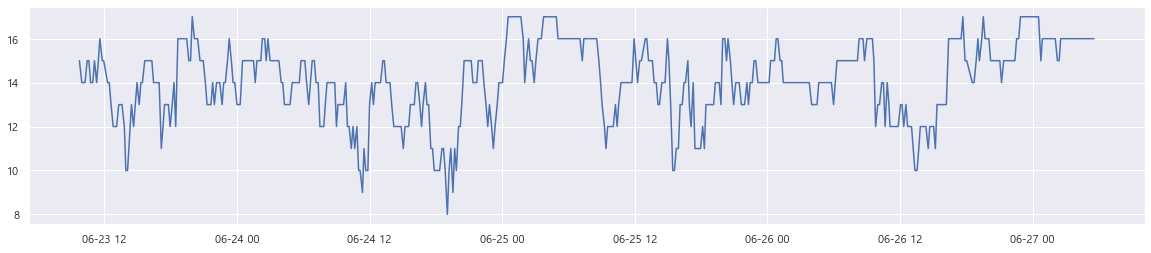

In [11]:
plt.figure(figsize=(20,4))
plt.plot(train_data)
plt.savefig('../OUT/EDA/'+str(list(dflist.keys())[0])+' data trend')
plt.show()

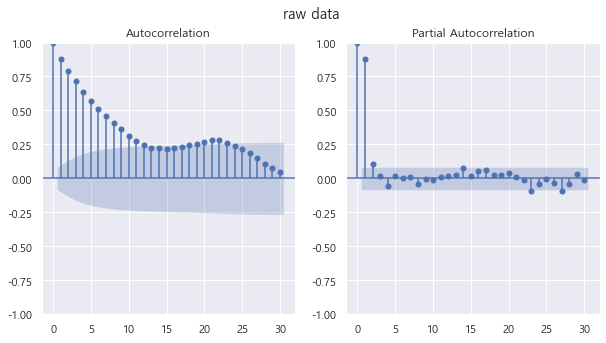

In [12]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
fig.suptitle('raw data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(),lags=30,ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(),lags=30,ax=ax[1])
plt.savefig('../OUT/Preprocessing/'+str(list(dflist.keys())[0])+' acf_pacf')
plt.show()

### 자기상관 그래프를 보아 정상성 검정 필요
정상성 검정을 위해 adfuller, kpss 함수 사용

- adfuller :: H0 : non-stationary,  H1 : stationary

- kpss :: H0 : stationary,  H1 : non-stationary


위의 그림들을 참고해서 비정상성(차분이나 로그전환이 필요)인지 확인하고 arima(p,q,d)를 결정

In [13]:
#정상성 확인 검정테스트
def adf_test(timeseries, pvalue = .05, regression_option = 'ct'):
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return(dfoutput)

pvalue = .05
dfoutput = adf_test(train_data)

print ('Results of Dickey-Fuller Test:')
print (dfoutput)

print('\nH0 : non-stationary')
print('H1 : stationary')

if dfoutput[1] < pvalue:
    print('\np-value = ', round(dfoutput[1], 4))
    print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.")
else:
    print('\np-value = ', round(dfoutput[1], 4))
    print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성을 보장하지 못합니다.")

Results of Dickey-Fuller Test:
Test Statistic                  -5.283288
p-value                          0.000061
Lags Used                        1.000000
Number of Observations Used    539.000000
Critical Value (1%)             -3.975665
Critical Value (5%)             -3.418667
Critical Value (10%)            -3.131861
dtype: float64

H0 : non-stationary
H1 : stationary

p-value =  0.0001
정상시계열이 아니라는 귀무가설을 5.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.


정상성 검정 결과, 만족

In [14]:
def kpss_test(timeseries, pvalue = .05, regression_option = 'ct'):
    kpsstest = kpss(timeseries, regression= regression_option)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    return(kpss_output)

pvalue = .05
kpss_output = kpss_test(train_data)

print ('Results of KPSS Test:')
print (kpss_output)

print('\nH0 : stationary')
print('H1 : non-stationary')

if kpss_output[1] < pvalue:
    print('\np-value = ', round(kpss_output[1], 4))
    print(f"정상시계열이 맞다는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성을 보장하지 못합니다.")
else:
    print('\np-value = ', round(kpss_output[1], 4))
    print(f"정상시계열이 맞다는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.")

Results of KPSS Test:
Test Statistic            0.112007
p-value                   0.100000
Lags Used                14.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64

H0 : stationary
H1 : non-stationary

p-value =  0.1
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.


정상성 검정 결과, 만족

### 차분 실행
정상성을 만족하기에 차분이 불필요하나 경험 상의 이유로 실행해 봄

In [15]:
#차분
diff_train_data=train_data.copy()
diff_train_data=diff_train_data['available_bed_num'].diff()
diff_train_data=diff_train_data.dropna()
print('########################differenced data######################')
print(diff_train_data)

########################differenced data######################
record_time
2023-06-23 09:56:42   -1.0
2023-06-23 10:04:52    0.0
2023-06-23 10:14:13    0.0
2023-06-23 10:25:53    1.0
2023-06-23 10:35:13    0.0
                      ... 
2023-06-27 04:53:16    0.0
2023-06-27 05:02:36    0.0
2023-06-27 05:14:16    0.0
2023-06-27 05:23:37    0.0
2023-06-27 05:32:57    0.0
Name: available_bed_num, Length: 540, dtype: float64


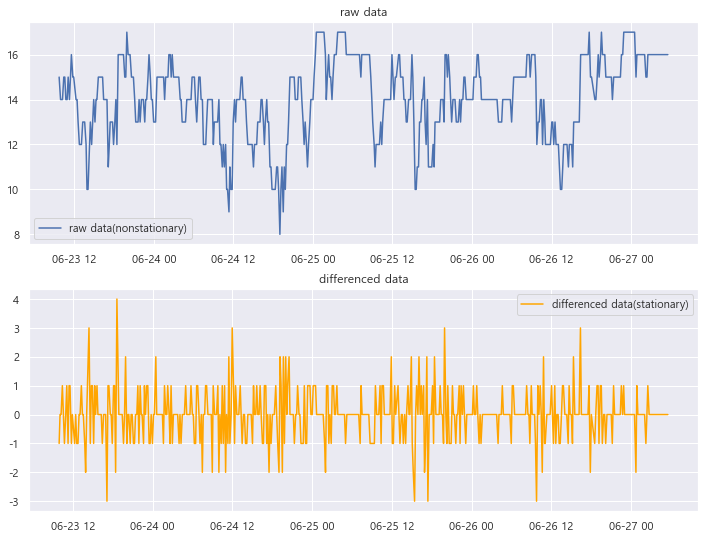

In [16]:
#차분 plot
plt.figure(figsize=(12,9))
plt.subplot(211)
plt.plot(train_data['available_bed_num'])
plt.legend(['raw data(nonstationary)'])
plt.title('raw data')
plt.subplot(212)
plt.plot(diff_train_data,'orange')
plt.legend(['differenced data(stationary)'])
plt.title('differenced data')
plt.savefig('../OUT/Preprocessing/'+str(list(dflist.keys())[0])+' differenced trend')
plt.show()

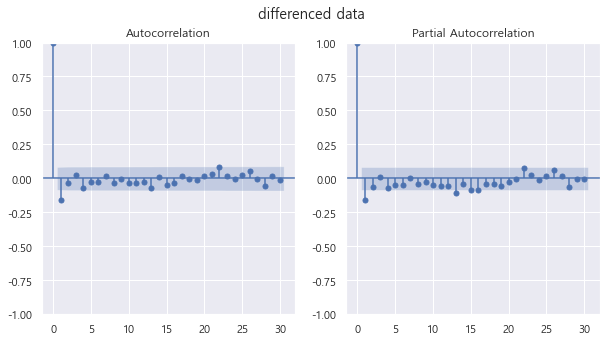

In [17]:
#차분한 acf,pacf
fig,ax=plt.subplots(1,2,figsize=(10,5))
fig.suptitle('differenced data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(),lags=30,ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(),lags=30,ax=ax[1])
plt.savefig('../OUT/Preprocessing/'+str(list(dflist.keys())[0])+' differenced acf_pacf')
plt.show()

차분 결과 데이터의 정상성이 더욱 보강된 모습

## Modeling 
auto arima를 사용해 최적의 모수 찾기

In [18]:
auto_arima_model = auto_arima(train_data, start_p=0, start_q=0, 
                      max_p=5, max_q=5,
                      d=0,
                      seasonal=False,  # 계절성 XX
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print('AIC = ', auto_arima_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4407.766, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3710.300, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1367.956, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1369.154, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3185.430, Time=0.60 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1370.440, Time=1.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1340.847, Time=0.41 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1741.064, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1344.690, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1342.825, Time=0.79 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1342.803, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2137.8

In [19]:
from sklearn.metrics import mean_squared_error 

test_pred=auto_arima_model.predict(len(test_data),return_conf_int=True)
train_pred=auto_arima_model.predict(len(train_data),return_conf_int=True)
test_pred_val=test_pred[0]
train_pred_val=train_pred[0]

test_mse = mean_squared_error(test_data.values, test_pred[0])
train_mse = mean_squared_error(train_data.values, train_pred[0])

print(list(dflist.keys())[0], 'Auto ARIMA Model\n')
print('AIC :: ', auto_arima_model.aic())
print('test_rmse::  ', test_mse**2)
print('train_rmse:: ', train_mse**2)

의료법인강릉동인병원 Auto ARIMA Model

AIC ::  1340.846571197673
test_rmse::   9.716494205795547
train_rmse::  9.314298305726942


# 다른 데이터도 분석 진행

### EDA

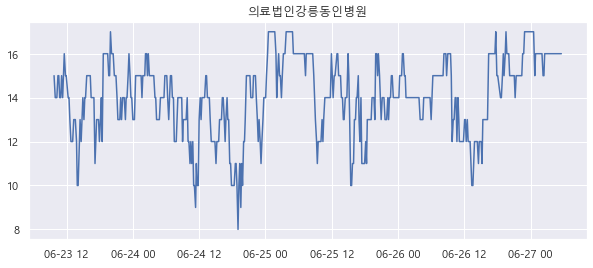

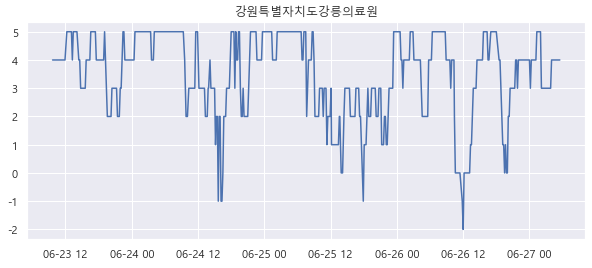

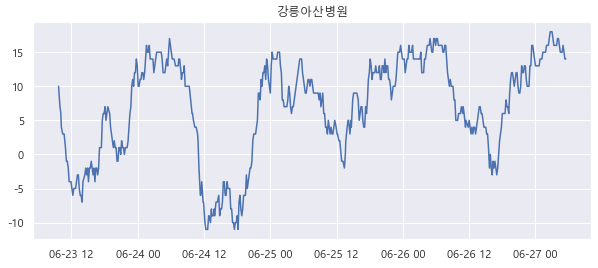

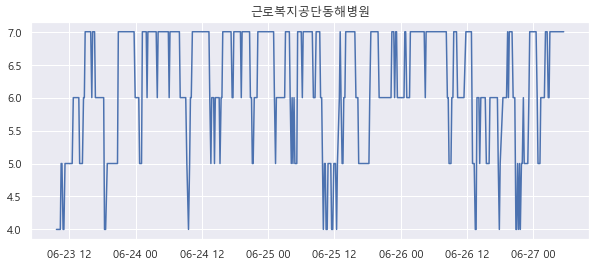

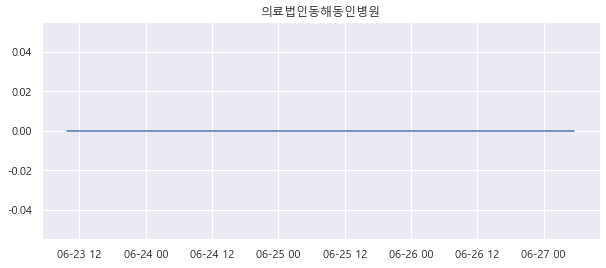

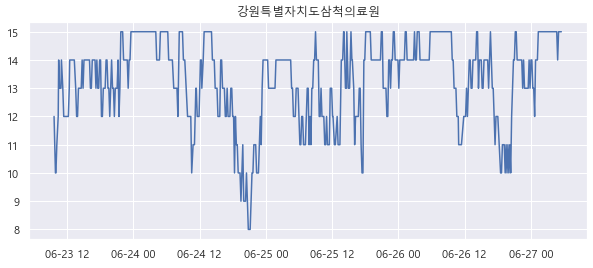

In [20]:
for i in range(0, 6):
    data = dflist[list(dflist.keys())[i]]
    train_data=data[0:541]
    test_data=data[542:]
    
    plt.figure(figsize=(10,4))
    plt.plot(train_data)
    plt.title(str(list(dflist.keys())[i]))
    plt.savefig('../OUT/EDA/'+str(list(dflist.keys())[i])+' data trend')
    plt.show()

#### 의료법인 동해동인병원은 모든 데이터가 0으로 trend가 없어 분석에서 제외함

In [21]:
del dflist['의료법인동해동인병원']

### ACF, PACF 그래프 시각화

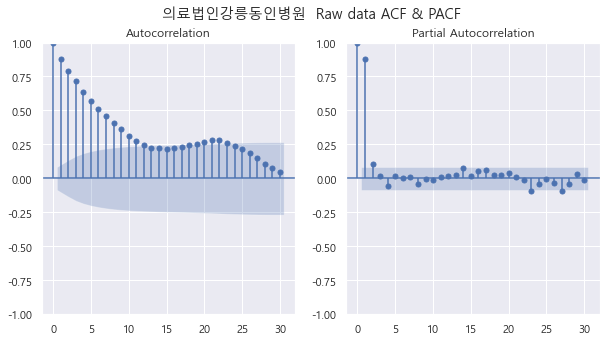

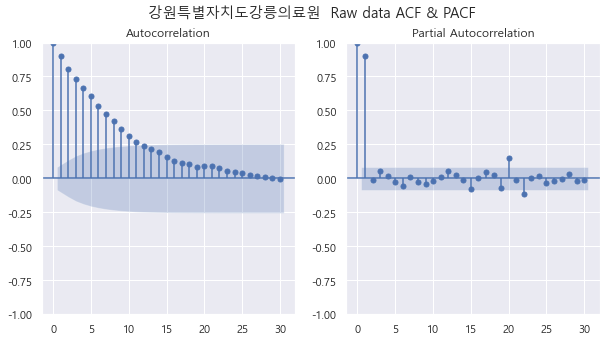

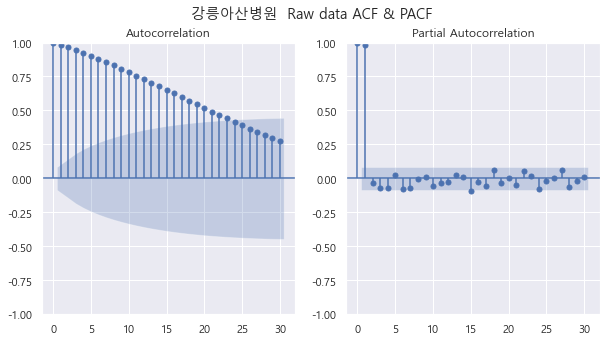

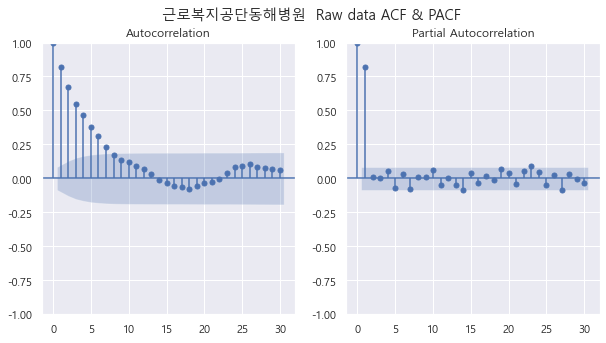

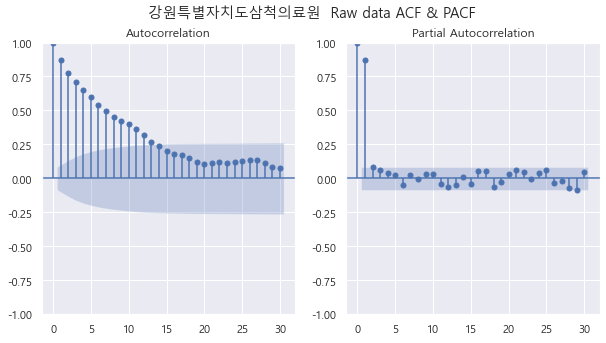

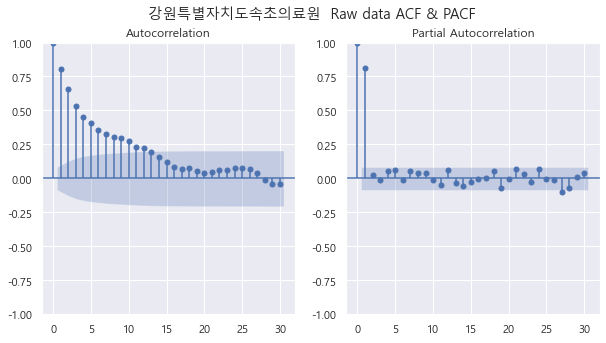

In [22]:
for i in range(0, 6):
    data = dflist[list(dflist.keys())[i]]
    train_data=data[0:541]
    test_data=data[542:]
    
    fig,ax=plt.subplots(1,2,figsize=(10,5))
    fig.suptitle(str(list(dflist.keys())[i]) + '  Raw data ACF & PACF')
    sm.graphics.tsa.plot_acf(train_data.values.squeeze(),lags=30,ax=ax[0])
    sm.graphics.tsa.plot_pacf(train_data.values.squeeze(),lags=30,ax=ax[1])
    plt.savefig('../OUT/Preprocessing/'+str(list(dflist.keys())[i])+' acf_pacf')
    plt.show()

그래프를 보았을 때, 강릉아산병원의 경우, 비정상성의 위험이 있음에 주의

## 함수 정의
- auto_arima_model(train_data) 

  :: auto_arima 실행 후 최적 모델 반환
  
  
 - model_Evaluation(auto_arima_model, test_data, train_data)
 
   :: 모형의 train_RMSE, test_RMSE, AIC 반환
   
   
 - model_predict(auto_arima_model, test_data)
   
   :: test 예측값, 예측값 상위신뢰구간, 하위 신뢰구간 반환

In [23]:
def auto_arima_model(train_data):
    # 정상성 검정
    pvalue = .05
    dfoutput = adf_test(train_data)
    kpss_output = kpss_test(train_data)
    
    # 정상성 만족
    if (dfoutput[1] < pvalue) and (kpss_output[1] < pvalue):    
        auto_best_model = auto_arima(train_data, start_p=1, start_q=0,  start_P=0, max_p=5, max_q=5,d=0,
                                     seasonal=False, D=0,
                                     trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
    else:
        auto_best_model = auto_arima(train_data, start_p=0, start_q=0,  start_P=0, max_p=5, max_q=5,d=1,
                                     seasonal=False, D=0,
                                     trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
    return(auto_best_model)

In [24]:
def model_Evaluation(auto_arima_model, test_data, train_data):
    test_pred=auto_arima_model.predict(len(test_data),return_conf_int=True)
    train_pred=auto_arima_model.predict(len(train_data),return_conf_int=True)
    
    test_pred_val=test_pred[0]
    train_pred_val=train_pred[0]

    test_mse = mean_squared_error(test_data.values, test_pred[0])
    train_mse = mean_squared_error(train_data.values, train_pred[0])
    
    aic = auto_arima_model.aic()
    
    return(test_mse**0.5, train_mse**0.5, aic)

In [25]:
def model_predict(auto_arima_model, test_data):
    test_pred=auto_arima_model.predict(len(test_data),return_conf_int=True)
    
    pred_val = test_pred[0]
    pred_ub=test_pred[1][:,0]
    pred_lb=test_pred[1][:,1]
    
    return(pred_val, pred_ub, pred_lb)

In [26]:
# train test split
hospital = list()
model_list = list()
AIC = list()
train_rmse = list()
test_rmse = list()
test_pred_val = list()
pred_ub = list()
pred_lb = list()

for i in range(0, 6):
    print(list(dflist.keys())[i])
    
    split_rate = 0.8
    data = dflist[list(dflist.keys())[i]].copy()
    train_data=data[0:int(len(data)*split_rate)]
    test_data=data[int(len(data)*split_rate)+1:]

    model_list.append(auto_arima_model(train_data))

    trainrmse, testrmse, modelaic = model_Evaluation(model_list[i], test_data, train_data)
    testpredval, predUB, predLB = model_predict(model_list[i], test_data)
    
    hospital.append(list(dflist.keys())[i])
    train_rmse.append(trainrmse)
    test_rmse.append(testrmse)
    AIC.append(modelaic)
    test_pred_val.append(testpredval)
    
    pred_ub.append(predUB)
    pred_lb.append(predLB)
    
    print('\n')

의료법인강릉동인병원
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1373.043, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1361.398, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1359.953, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1371.045, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1361.133, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.41 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1357.958, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1359.139, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1359.403, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.83 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.341 seconds


강원특별자치도강릉의료원
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : A

In [27]:
Evaluation_result = {'hospital':hospital, 'model_list':model_list, 'AIC':AIC, 'train_rmse':train_rmse, 'test_rmse':test_rmse,}
Evaluation_result_df = pd.DataFrame(Evaluation_result)

pred_result = {'hospital':hospital,'test_pred_val':test_pred_val, 'pred_ub':pred_ub, 'pred_lb':pred_lb}
pred_result_df = pd.DataFrame(pred_result)

In [28]:
dfi.export(Evaluation_result_df, '../OUT/Inference/Raw_Evaluation_result_df.png')
Evaluation_result_df

,hospital,model_list,AIC,train_rmse,test_rmse
0,의료법인강릉동인병원,"ARIMA(0,1,1)(0,0,0)[0]",1357.957935,2.567604,2.583897
1,강원특별자치도강릉의료원,"ARIMA(0,1,0)(0,0,0)[0]",1078.244461,1.151489,1.530346
2,강릉아산병원,"ARIMA(0,1,0)(0,0,0)[0]",1841.764663,9.963266,10.214610
3,근로복지공단동해병원,"ARIMA(2,1,5)(0,0,0)[0] intercept",799.261967,1.048788,1.182758
4,강원특별자치도삼척의료원,"ARIMA(1,0,2)(0,0,0)[0] intercept",1211.851355,1.573366,1.542243
5,강원특별자치도속초의료원,"ARIMA(1,1,5)(0,0,0)[0] intercept",1284.814495,1.125429,1.611201


In [29]:
pred_result_df

,hospital,test_pred_val,pred_ub,pred_lb
0,의료법인강릉동인병원,541 16.0 542 16.0 543 16.0 544 16....,"[14.338669427613102, 13.845926103639489, 13.44...","[17.66133057238689, 18.154073896360504, 18.553..."
1,강원특별자치도강릉의료원,541 4.0 542 4.0 543 4.0 544 4.0 54...,"[2.71531939947282, 2.1831872713622715, 1.77486...","[5.28468060052718, 5.8168127286377285, 6.22513..."
2,강릉아산병원,541 14.0 542 14.0 543 14.0 544 14....,"[11.394901123561432, 10.315833837565247, 9.487...","[16.605098876438568, 17.684166162434753, 18.51..."
3,근로복지공단동해병원,541 6.895213 542 6.809011 543 6.74138...,"[5.918244484055758, 5.534117553106481, 5.29750...","[7.872181052452093, 8.083904220680676, 8.18526..."
4,강원특별자치도삼척의료원,541 14.819375 542 14.682477 543 14.57...,"[13.38117998369032, 12.856519048415002, 12.522...","[16.25757074154769, 16.508434955135073, 16.618..."
5,강원특별자치도속초의료원,541 18.831572 542 18.703908 543 18.60...,"[17.33263775499753, 16.807096962609535, 16.471...","[20.330506344014527, 20.6007199886622, 20.7292..."


## 예측 시각화

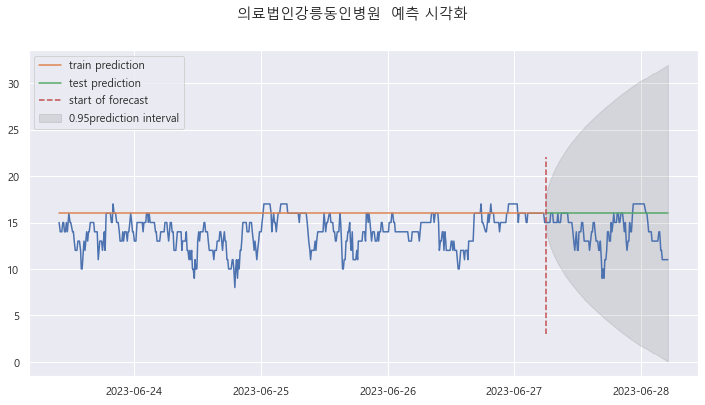

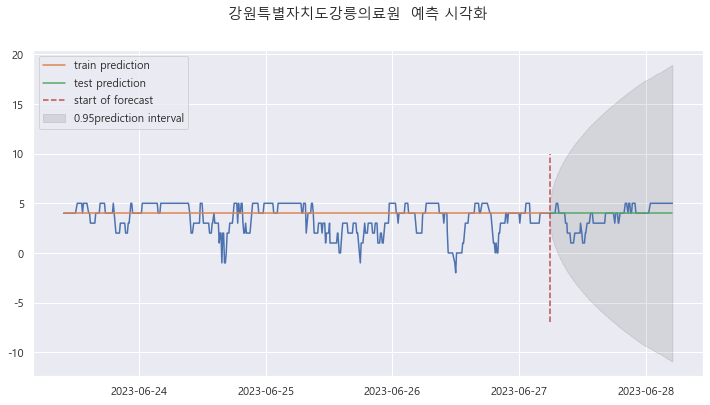

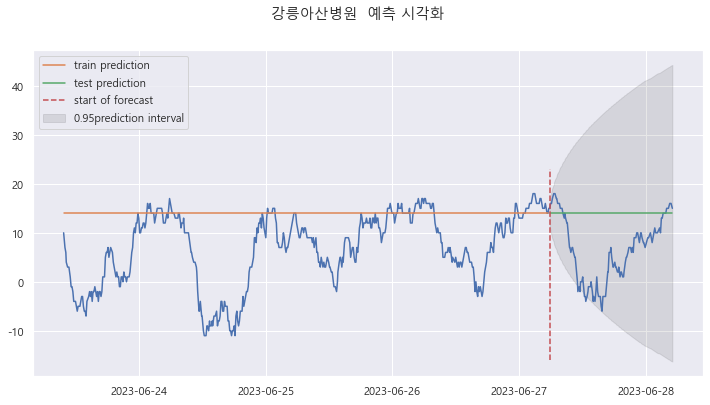

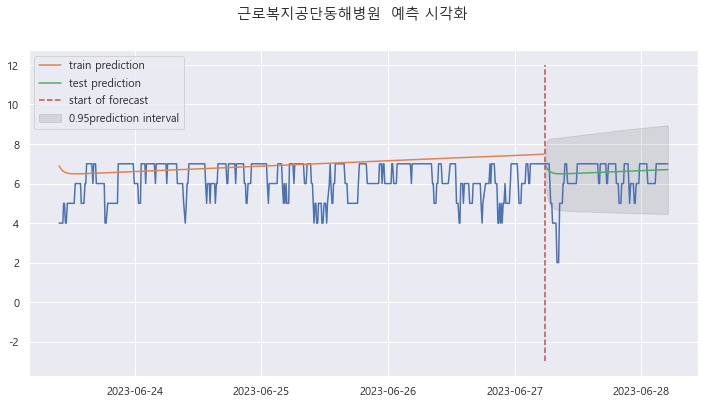

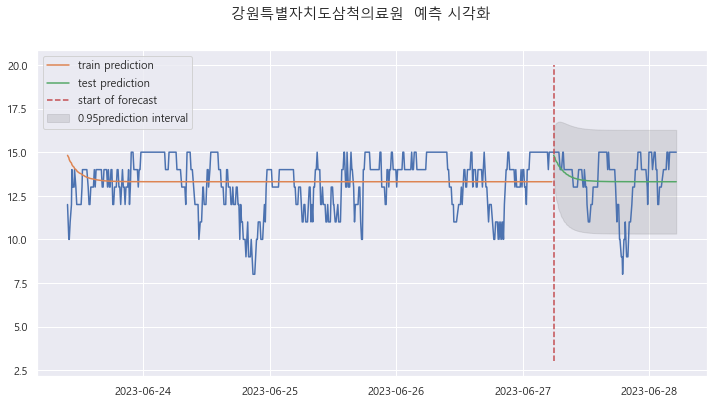

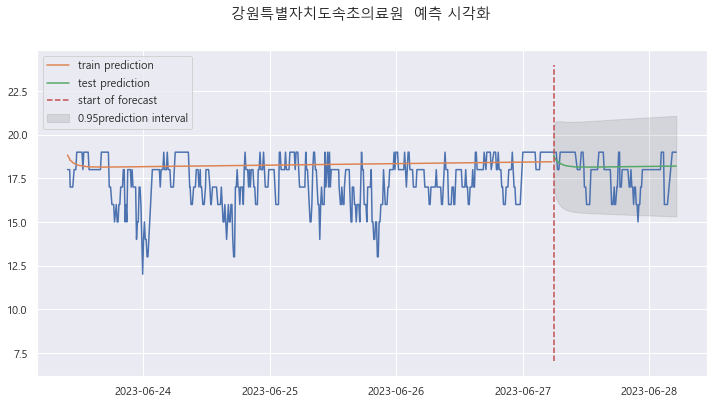

In [30]:
for i in range(0, 6):
    split_rate = 0.8
    data = dflist[list(dflist.keys())[i]].copy()
    train_data=data[0:int(len(data)*split_rate)]
    test_data=data[int(len(data)*split_rate)+1:]
    
    pred_idx = list(test_data.index)
    pred_val = pred_result_df.iloc[i, 1]
    train_pred = Evaluation_result_df.iloc[i, 1].predict(len(train_data),return_conf_int=True)
    pred_ub = pred_result_df.iloc[i, 2]
    pred_lb = pred_result_df.iloc[i, 3]
    
    fig,ax = plt.subplots(figsize=(12,6))
    ax.plot(data)
    ax.plot(list(train_data.index), train_pred[0],label='train prediction')
    ax.plot(pred_idx, pred_val,label='test prediction')
    ax.vlines(pred_idx[0],min(data['available_bed_num'])-5, max(data['available_bed_num'])+5,
              linestyle='--',color='r',label='start of forecast')
    fig.suptitle(str(list(dflist.keys())[i]) + '  예측 시각화')
    ax.fill_between(pred_idx,pred_lb,pred_ub,color='k',alpha=0.1,label='0.95prediction interval')
    ax.legend(loc = 'upper left')
    
    # 그림 저장
    plt.savefig('../OUT/Inference/'+str(list(dflist.keys())[i])+'_raw_prediction')
    plt.show()

데이터 추세가 반영이 잘 안되는 모습


# 시간별 평균

In [31]:
hour_mean_dflist = {}
for i in range(0, 6):
    hospital_name = list(dflist.keys())[i]
    hour_mean_dflist[hospital_name] = dflist[hospital_name].copy().resample(rule='1H').mean()

<AxesSubplot:xlabel='record_time'>

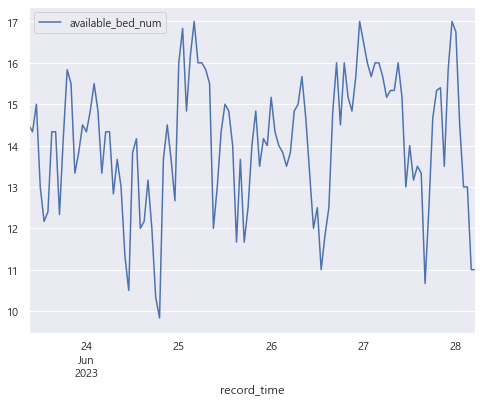

In [32]:
hour_mean_dflist['의료법인강릉동인병원'].plot()

In [33]:
# train test split
hospital = list()
HM_model_list = list()
HM_AIC = list()
HM_train_rmse = list()
HM_test_rmse = list()
HM_test_pred_val = list()
HM_pred_ub = list()
HM_pred_lb = list()

for i in range(0, 6):
    print(list(hour_mean_dflist.keys())[i])
    hospital.append(list(hour_mean_dflist.keys())[i])
    
    split_rate = 0.8
    HM_data = hour_mean_dflist[list(hour_mean_dflist.keys())[i]].copy()
    HM_train_data=HM_data[0:int(len(HM_data)*split_rate)]
    HM_test_data=HM_data[int(len(HM_data)*split_rate)+1:]

    HM_model_list.append(auto_arima_model(HM_train_data))

    HM_trainrmse, HM_testrmse, HM_modelaic = model_Evaluation(HM_model_list[i], HM_test_data, HM_train_data)
    HM_testpredval, HM_predUB, HM_predLB = model_predict(HM_model_list[i], HM_test_data)
    
    HM_train_rmse.append(HM_trainrmse)
    HM_test_rmse.append(HM_testrmse)
    HM_AIC.append(HM_modelaic)
    HM_test_pred_val.append(HM_testpredval)
    HM_pred_ub.append(HM_predUB)
    HM_pred_lb.append(HM_predLB)
    
    print('\n')

의료법인강릉동인병원
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=314.055, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=315.396, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=313.420, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=312.064, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.672 seconds


강원특별자치도강릉의료원
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=267.053, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=267.871, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=265.997, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=265.053, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=265.283, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.385 seconds


강릉아산병원
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   

In [34]:
HM_Evaluation_result = {'hospital':hospital, 'model_list':HM_model_list, 'AIC':HM_AIC, 'train_rmse':HM_train_rmse, 'test_rmse':HM_test_rmse,}
HM_Evaluation_result_df = pd.DataFrame(HM_Evaluation_result)

HM_pred_result = {'hospital':hospital,'test_pred_val':HM_test_pred_val, 'pred_ub':HM_pred_ub, 'pred_lb':HM_pred_lb}
HM_pred_result_df = pd.DataFrame(HM_pred_result)

In [35]:
dfi.export(HM_Evaluation_result_df, '../OUT/Inference/1hour_mean_Evaluation_result_df.png')
HM_Evaluation_result_df

,hospital,model_list,AIC,train_rmse,test_rmse
0,의료법인강릉동인병원,"ARIMA(0,1,0)(0,0,0)[0]",312.063786,2.376366,2.221840
1,강원특별자치도강릉의료원,"ARIMA(0,1,0)(0,0,0)[0]",265.052929,1.105700,1.394306
2,강릉아산병원,"ARIMA(0,1,1)(0,0,0)[0]",453.074559,10.223742,10.518182
3,근로복지공단동해병원,"ARIMA(0,1,0)(0,0,0)[0]",203.375335,1.113987,1.100934
4,강원특별자치도삼척의료원,"ARIMA(0,1,3)(0,0,0)[0]",250.677338,1.727862,1.735592
5,강원특별자치도속초의료원,"ARIMA(0,1,3)(0,0,0)[0]",256.969345,0.912847,1.135128


In [36]:
HM_pred_result_df.head(2)

,hospital,test_pred_val,pred_ub,pred_lb
0,의료법인강릉동인병원,2023-06-27 06:00:00 15.666667 2023-06-27 07...,"[13.10895538488467, 12.049516683378409, 11.236...","[18.224377948448662, 19.28381664995492, 20.096..."
1,강원특별자치도강릉의료원,2023-06-27 06:00:00 4.0 2023-06-27 07:00:00...,"[2.0189685967551867, 1.1983985220386772, 0.568...","[5.981031403244813, 6.801601477961323, 7.43124..."


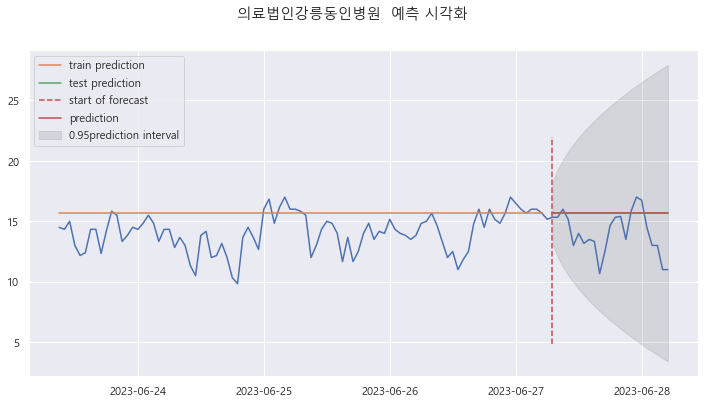

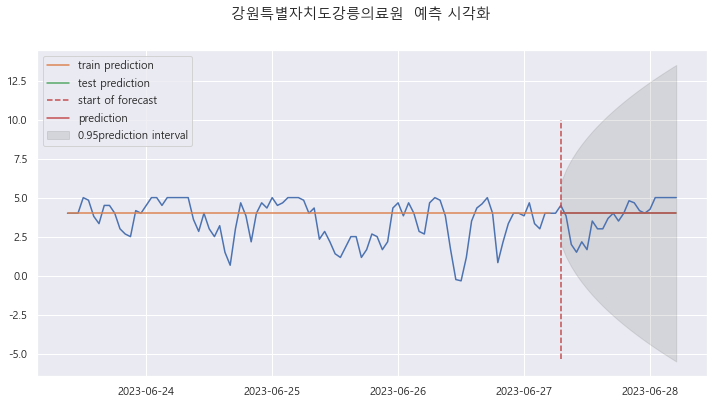

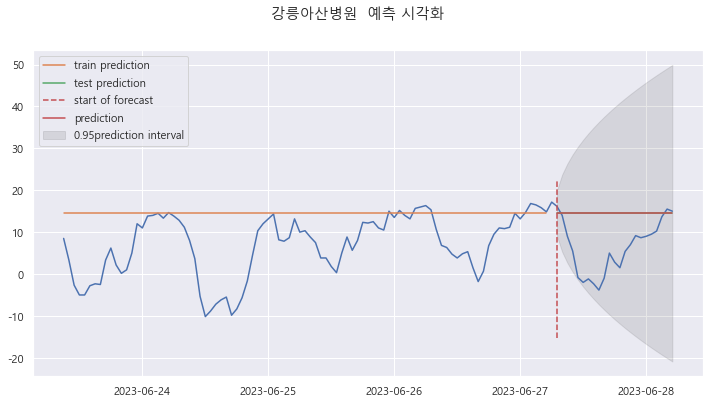

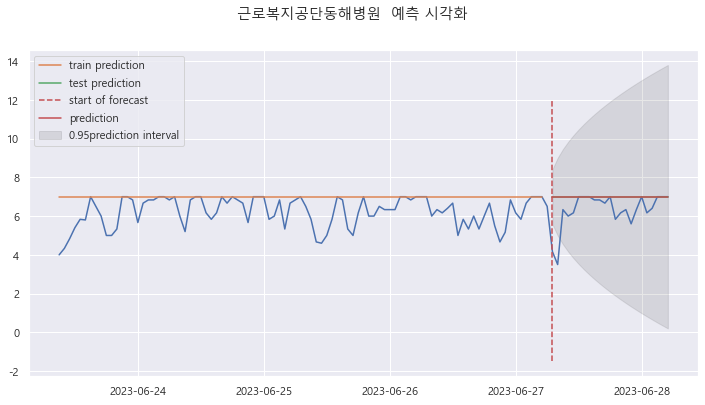

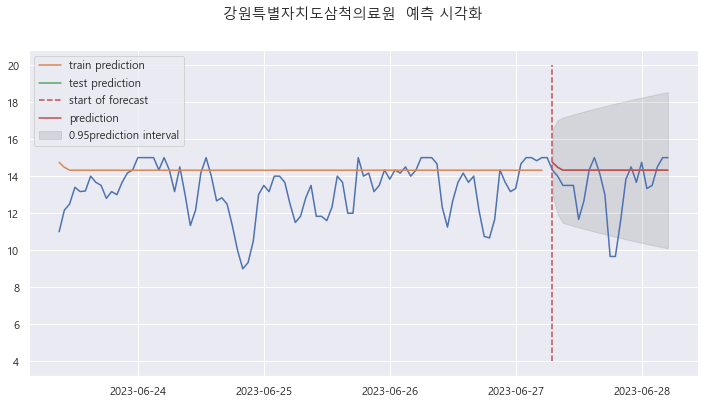

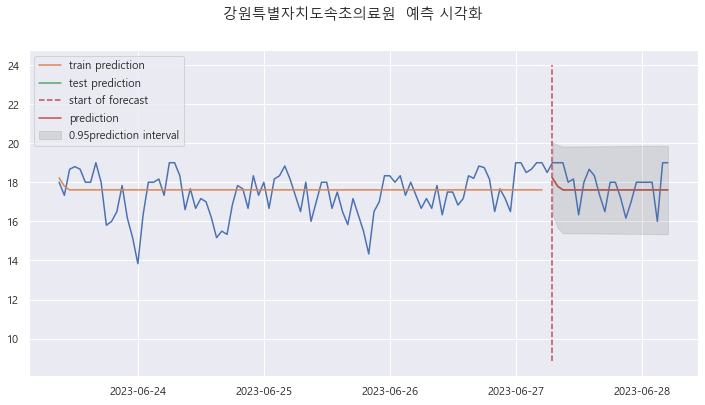

In [37]:
for i in range(0, 6):
    split_rate = 0.8
    HM_data = hour_mean_dflist[list(hour_mean_dflist.keys())[i]].copy()
    HM_train_data=HM_data[0:int(len(HM_data)*split_rate)]
    HM_test_data=HM_data[int(len(HM_data)*split_rate)+1:]

    pred_idx = list(HM_test_data.index)
    pred_val = HM_pred_result_df.iloc[i, 1]
    train_pred = HM_Evaluation_result_df.iloc[i, 1].predict(len(HM_train_data),return_conf_int=True)
    pred_ub = HM_pred_result_df.iloc[i, 2]
    pred_lb = HM_pred_result_df.iloc[i, 3]


    fig,ax=plt.subplots(figsize=(12,6))
    ax.plot(HM_data)
    ax.plot(list(HM_train_data.index), train_pred[0],label='train prediction')
    ax.plot(pred_idx, pred_val,label='test prediction')
    ax.vlines(pred_idx[0],min(HM_data['available_bed_num'])-5, max(HM_data['available_bed_num'])+5,
              linestyle='--',color='r',label='start of forecast')
    plt.plot(pred_idx, pred_val,label='prediction')
    fig.suptitle(str(list(dflist.keys())[i]) + '  예측 시각화')
    ax.fill_between(pred_idx,pred_lb,pred_ub,color='k',alpha=0.1,label='0.95prediction interval')
    ax.legend(loc = 'upper left')
    
    # 그림 저장
    plt.savefig('../OUT/Inference/'+str(list(dflist.keys())[i])+'_1hour_mean_prediction')
    plt.show()

# 2시간 간격 평균

In [38]:
hour2_mean_dflist = {}
for i in range(0, 6):
    hospital_name = list(dflist.keys())[i]
    hour2_mean_dflist[hospital_name] = dflist[hospital_name].copy().resample(rule='2H').mean()

<AxesSubplot:xlabel='record_time'>

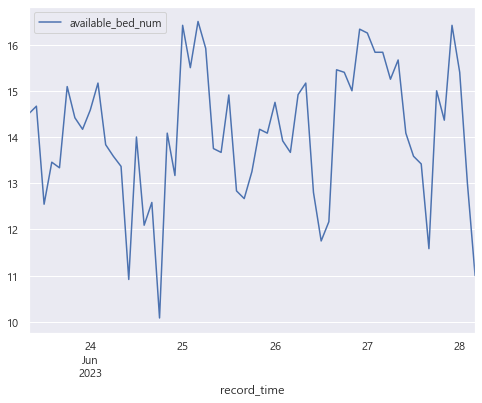

In [39]:
hour2_mean_dflist['의료법인강릉동인병원'].plot()

In [40]:
# train test split
hospital = list()
H2M_model_list = list()
H2M_AIC = list()
H2M_train_rmse = list()
H2M_test_rmse = list()
H2M_test_pred_val = list()
H2M_pred_ub = list()
H2M_pred_lb = list()

for i in range(0, 6):
    print(list(hour2_mean_dflist.keys())[i])
    hospital.append(list(hour2_mean_dflist.keys())[i])
    
    split_rate = 0.8
    H2M_data = hour2_mean_dflist[list(hour2_mean_dflist.keys())[i]].copy()
    H2M_train_data=H2M_data[0:int(len(H2M_data)*split_rate)]
    H2M_test_data=H2M_data[int(len(H2M_data)*split_rate)+1:]

    H2M_model_list.append(auto_arima_model(H2M_train_data))

    H2M_trainrmse, H2M_testrmse, H2M_modelaic = model_Evaluation(H2M_model_list[i], H2M_test_data, H2M_train_data)
    H2M_testpredval, H2M_predUB, H2M_predLB = model_predict(H2M_model_list[i], H2M_test_data)
    
    H2M_train_rmse.append(H2M_trainrmse)
    H2M_test_rmse.append(H2M_testrmse)
    H2M_AIC.append(H2M_modelaic)
    H2M_test_pred_val.append(H2M_testpredval)
    H2M_pred_ub.append(H2M_predUB)
    H2M_pred_lb.append(H2M_predLB)
    
    print('\n')

의료법인강릉동인병원
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=170.701, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=165.435, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=165.340, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=168.719, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=166.066, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=167.261, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=167.328, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=163.434, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=164.084, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=165.386, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=163.472, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=165.370, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.141 seconds


강원특별자치도강릉의료원
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] interce

In [41]:
H2M_Evaluation_result = {'hospital':hospital, 'model_list':H2M_model_list, 'AIC':H2M_AIC, 
                         'train_rmse':H2M_train_rmse, 'test_rmse':H2M_test_rmse,}
H2M_Evaluation_result_df = pd.DataFrame(H2M_Evaluation_result)

H2M_pred_result = {'hospital':hospital,'test_pred_val':H2M_test_pred_val, 'pred_ub':H2M_pred_ub, 'pred_lb':H2M_pred_lb}
H2M_pred_result_df = pd.DataFrame(H2M_pred_result)

In [42]:
dfi.export(H2M_Evaluation_result_df, '../OUT/Inference/2hour_mean_Evaluation_result_df.png')
H2M_Evaluation_result_df

,hospital,model_list,AIC,train_rmse,test_rmse
0,의료법인강릉동인병원,"ARIMA(0,1,1)(0,0,0)[0]",163.433811,2.492566,2.276720
1,강원특별자치도강릉의료원,"ARIMA(0,1,0)(0,0,0)[0]",152.035913,1.044081,1.283270
2,강릉아산병원,"ARIMA(0,1,0)(0,0,0)[0]",270.397290,10.991981,10.974490
3,근로복지공단동해병원,"ARIMA(0,1,1)(0,0,0)[0]",103.661199,0.604149,0.818725
4,강원특별자치도삼척의료원,"ARIMA(0,1,1)(0,0,0)[0]",156.587227,1.941165,1.977005
5,강원특별자치도속초의료원,"ARIMA(0,1,0)(0,0,0)[0]",136.428665,1.478409,1.888965


In [43]:
H2M_pred_result_df.head(2)

,hospital,test_pred_val,pred_ub,pred_lb
0,의료법인강릉동인병원,2023-06-27 06:00:00 15.869654 2023-06-27 08...,"[13.192338823714923, 12.779145909898215, 12.41...","[18.54696947214905, 18.96016238596576, 19.3242..."
1,강원특별자치도강릉의료원,2023-06-27 06:00:00 4.0 2023-06-27 08:00:00...,"[1.5774842276335224, 0.5740453396408864, -0.19...","[6.422515772366477, 7.425954660359114, 8.19592..."


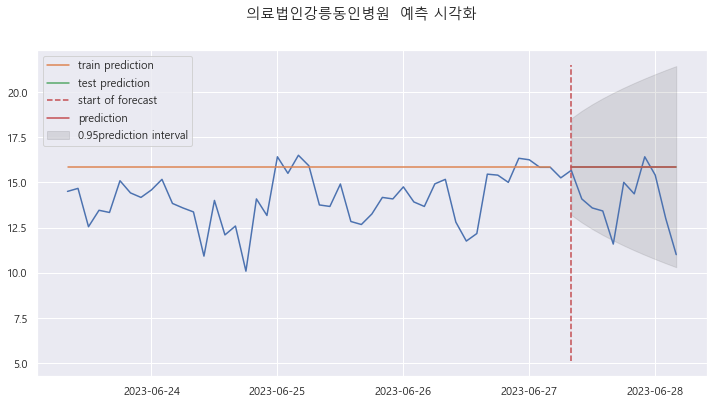

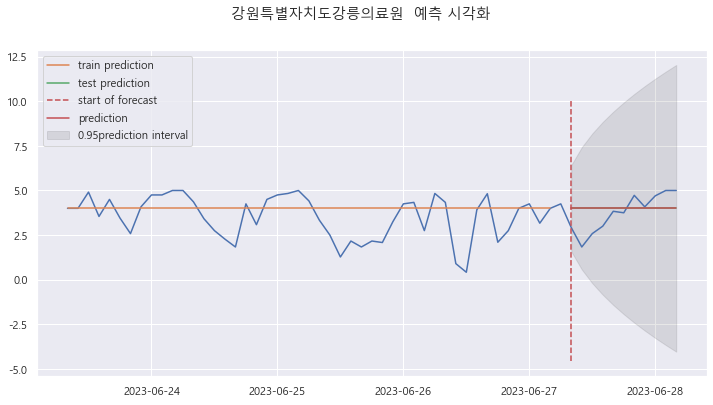

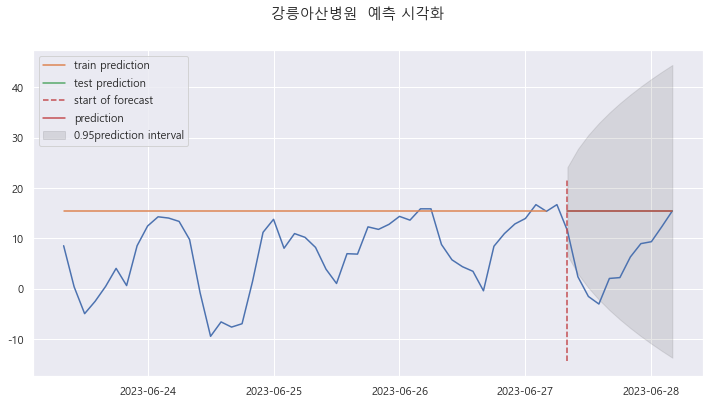

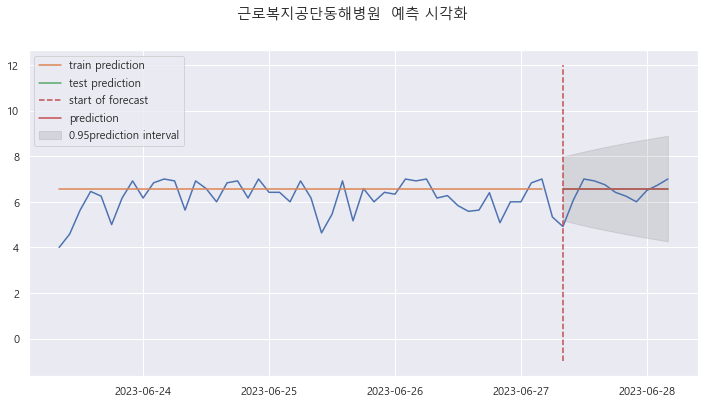

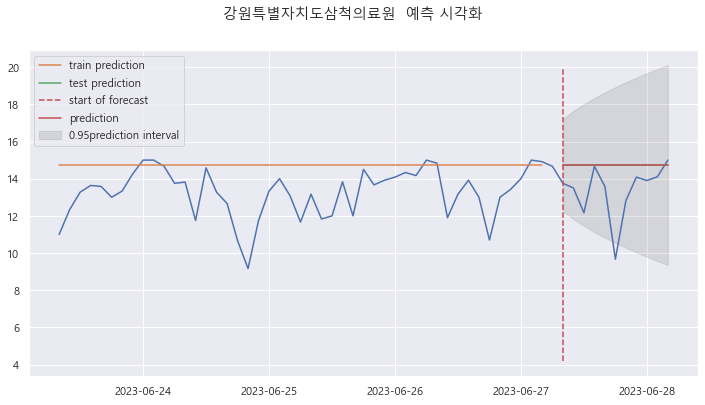

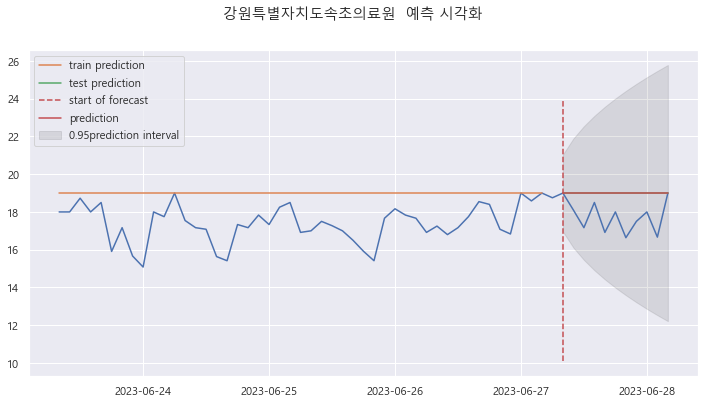

In [44]:
for i in range(0, 6):
    split_rate = 0.8
    H2M_data = hour2_mean_dflist[list(hour2_mean_dflist.keys())[i]].copy()
    H2M_train_data=H2M_data[0:int(len(H2M_data)*split_rate)]
    H2M_test_data=H2M_data[int(len(H2M_data)*split_rate)+1:]

    pred_idx = list(H2M_test_data.index)
    pred_val = H2M_pred_result_df.iloc[i, 1]
    train_pred = H2M_Evaluation_result_df.iloc[i, 1].predict(len(H2M_train_data),return_conf_int=True)
    pred_ub = H2M_pred_result_df.iloc[i, 2]
    pred_lb = H2M_pred_result_df.iloc[i, 3]


    fig,ax=plt.subplots(figsize=(12,6))
    ax.plot(H2M_data)
    ax.plot(list(H2M_train_data.index), train_pred[0],label='train prediction')
    ax.plot(pred_idx, pred_val,label='test prediction')
    ax.vlines(pred_idx[0],min(H2M_data['available_bed_num'])-5, max(H2M_data['available_bed_num'])+5,
              linestyle='--',color='r',label='start of forecast')
    plt.plot(pred_idx, pred_val,label='prediction')
    fig.suptitle(str(list(dflist.keys())[i]) + '  예측 시각화')
    ax.fill_between(pred_idx,pred_lb,pred_ub,color='k',alpha=0.1,label='0.95prediction interval')
    ax.legend(loc = 'upper left')
    
    # 그림 저장
    plt.savefig('../OUT/Inference/'+str(list(dflist.keys())[i])+'_2hour_mean_prediction')
    plt.show()

### BEST MODEL
기준:: RMSE

- 의료법인강릉동인병원  ::  1HM


- 강원특별자치도강릉의료원  ::  2HM 


- 강릉아산병원  ::  1HM


- 근로복지공단동해병원 ::  2 HM


- 강원특별자치도삼척의료원  ::  raw


- 강원특별자치도속초의료원  ::  1 HM

모델 저장

In [45]:
with open('../OUT/Modeling/의료법인강릉동인병원_1HM_ARIMA.pkl', 'wb') as pkl:
    pickle.dump(HM_Evaluation_result_df.iloc[0, 1], pkl)

with open('../OUT/Modeling/강원특별자치도강릉의료원_2HM_ARIMA.pkl', 'wb') as pkl:
    pickle.dump(HM_Evaluation_result_df.iloc[2, 1], pkl)    
    
with open('../OUT/Modeling/강릉아산병원_1HM_ARIMA.pkl', 'wb') as pkl:
    pickle.dump(H2M_Evaluation_result_df.iloc[3, 1], pkl)    

with open('../OUT/Modeling/근로복지공단동해병원_2HM_ARIMA.pkl', 'wb') as pkl:
    pickle.dump(H2M_Evaluation_result_df.iloc[3, 1], pkl)    
    
with open('../OUT/Modeling/강원특별자치도삼척의료원_RAW_ARIMA.pkl', 'wb') as pkl:
    pickle.dump(Evaluation_result_df.iloc[4, 1], pkl)    
    
with open('../OUT/Modeling/강원특별자치도속초의료원_RAW_ARIMA.pkl', 'wb') as pkl:
    pickle.dump(Evaluation_result_df.iloc[5, 1], pkl)    


모델 불러오기

In [46]:
with open('../OUT/Modeling/강원특별자치도속초의료원_RAW_ARIMA.pkl', 'rb') as pkl:
    model = pickle.load(pkl)

# 단순 지수 평활
좋지 X

In [47]:
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, 
                                         SimpleExpSmoothing, 
                                         Holt)

In [48]:
len(data)

677

In [49]:
i = 0
split_rate = 0.8
data = dflist[list(dflist.keys())[i]].copy()
train_data=data[0:int(len(data)*split_rate)]
test_data=data[int(len(data)*split_rate)+1:]

In [50]:
# SES (Simple Exponential Smoothing) / 단순 지수 평활

ses_1 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.2)
test_length = len(test_data)
ses_forecast_1 = ses_1.forecast(test_length)

ses_2 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.5)
ses_forecast_2 = ses_1.forecast(test_length)

# smoothing level을 지정하는 것이 아닌 최적 적합화(잔차 제곱합의 최소화) 하도록 함
ses_3 = SimpleExpSmoothing(train_data).fit()
alpha = ses_3.model.params['smoothing_level']
ses_forecast_3 = ses_3.forecast(test_length)

In [51]:
data.plot(color=COLORS[0], 
          title='Simple Exponential Smoothing',
          label='Actual',
          legend=False)

plt.plot(test_data.index, ses_forecast_1 ,color=COLORS[1])
ses_1.fittedvalues.plot(color=COLORS[1], label=r'$\alpha=0.2$')

plt.plot(test_data.index, ses_forecast_2 ,color=COLORS[2])
ses_2.fittedvalues.plot(color=COLORS[2], label=r'$\alpha=0.5$')

plt.plot(test_data.index, ses_forecast_3 ,color=COLORS[3])
ses_3.fittedvalues.plot(color=COLORS[3], label=r'$\alpha={0:.4f}$'.format(alpha))

plt.legend(loc='best')
plt.tight_layout()
plt.show()

type: name 'COLORS' is not defined

In [ ]:
ses_forecast_3
mean_squared_error(test_data.values, ses_forecast_3)

Holt's Model 

trend는 있지만 seasonality는 없는 경우에만

In [ ]:
# Holt 추세 방법

## 선형 추세 Holt
hs_1 = Holt(train_data).fit()
hs_forecast_1 = hs_1.forecast(test_length)


## 지수 추세 Holt
hs_2 = Holt(train_data, exponential = True).fit()
hs_forecast_2 = hs_2.forecast(test_length)

## 지수 추세 Holt + 감쇠
hs_3 = Holt(train_data, exponential = False, damped = True).fit(damping_slope = 0.99)
hs_forecast_3 = hs_3.forecast(test_length)

In [ ]:
data.plot(color=COLORS[0], 
          title='Simple Exponential Smoothing',
          label='Actual',
          legend=False)

plt.plot(test_data.index, hs_forecast_1 ,color=COLORS[1])
hs_1.fittedvalues.plot(color=COLORS[1], label=r'$\alpha=0.2$')

plt.plot(test_data.index, hs_forecast_2 ,color=COLORS[2])
hs_2.fittedvalues.plot(color=COLORS[2], label=r'$\alpha=0.5$')

plt.plot(test_data.index, hs_forecast_3 ,color=COLORS[3])
hs_3.fittedvalues.plot(color=COLORS[3], label=r'$\alpha={0:.4f}$'.format(alpha))

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
hs_forecast_3
mean_squared_error(test_data.values, hs_forecast_3)